# **PREDICTION OF MILLING MACHINE BEHAVIOR**

## IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split ,KFold
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
import xgboost

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler



## DATA LOADING AND ANALYSIS

Datasets elegido: https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020

In [3]:
df=pd.read_csv('./data/ai4i2020.csv',index_col=0)

In [4]:
df.head(10)

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
6,M14865,M,298.1,308.6,1425,41.9,11,0,0,0,0,0,0
7,L47186,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0
8,L47187,L,298.1,308.6,1527,40.2,16,0,0,0,0,0,0
9,M14868,M,298.3,308.7,1667,28.6,18,0,0,0,0,0,0


In [5]:
df['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

In [6]:
df['Type'][df['Machine failure']==1].value_counts()

Type
L    235
M     83
H     21
Name: count, dtype: int64

In [7]:
for i in range(10000):
    print(df.iloc[i].loc['Tool wear [min]'])

0
3
5
7
9
11
14
16
18
21
24
29
34
37
40
42
44
47
50
55
58
63
65
68
70
73
75
77
82
84
86
89
91
93
95
98
101
104
106
111
113
115
117
120
125
128
130
133
135
140
143
145
147
152
154
156
158
160
162
165
167
169
172
174
177
179
181
184
189
191
193
196
198
200
202
204
206
208
0
2
4
9
11
13
15
17
20
25
27
30
33
35
37
40
42
44
47
50
53
55
57
59
61
63
66
68
70
72
75
80
82
84
89
92
95
97
99
101
103
106
108
110
112
114
116
118
120
122
124
126
128
130
132
135
138
140
143
148
150
155
157
159
161
164
169
172
174
179
181
184
186
188
191
194
196
198
203
206
211
214
216
218
0
2
5
8
10
15
20
22
24
27
29
32
35
37
39
41
43
45
47
49
54
57
59
61
63
65
67
69
72
74
76
81
86
89
91
96
99
101
103
105
107
110
112
114
117
119
122
124
126
128
130
135
137
140
142
144
146
148
151
153
158
160
162
164
166
168
170
173
175
177
179
181
183
185
188
190
193
195
197
200
202
204
206
209
212
214
216
218
0
2
5
7
9
11
13
15
17
19
22
25
27
30
33
35
37
42
44
49
51
56
59
61
63
65
67
70
75
78
80
83
85
88
90
92
94
96
98
103
105
107
1

In [8]:
df.iloc[250,:]

Product ID                 L47430
Type                            L
Air temperature [K]         298.0
Process temperature [K]     308.3
Rotational speed [rpm]       1662
Torque [Nm]                  32.7
Tool wear [min]                 0
Machine failure                 0
TWF                             0
HDF                             0
PWF                             0
OSF                             0
RNF                             0
Name: 251, dtype: object

## FEATURE ENGINEERING

Eliminamos la columna de RNF

In [9]:
df=df.drop(columns='RNF')

Sacamos la variable potencia = torque x rot speed

In [10]:
#potencia_w = torque * (rpm * 2 * np.pi / 60) (para pasarlo a radianes)

df['Power [W]']=df['Torque [Nm]']*(df['Rotational speed [rpm]']*(2*np.pi/60))

In [11]:
df['Dissipation']=df['Process temperature [K]']-df['Air temperature [K]']

Aplicamos dummies para poder tener en cuenta los valores de dureza de la herramienta: L (Low),M (Medium) y H (High)

In [43]:
#Probado también con los valores medios de las durezas de cada tipo de herramienta, pero se obtuvo peores resultados:
""" df['Type'].replace('L',600,inplace=True)
df['Type'].replace('M',1000,inplace=True)
df['Type'].replace('H',2000,inplace=True) """

" df['Type'].replace('L',600,inplace=True)\ndf['Type'].replace('M',1000,inplace=True)\ndf['Type'].replace('H',2000,inplace=True) "

In [13]:
df = pd.get_dummies(df, columns=['Type'])

In [14]:
df_aux=df[['Machine failure','TWF','HDF','PWF','OSF']]
df=df.drop(columns=['Machine failure','TWF','HDF','PWF','OSF'])
df['Machine failure']=df_aux['Machine failure']
df['TWF']=df_aux['TWF']
df['HDF']=df_aux['HDF']
df['PWF']=df_aux['PWF']
df['OSF']=df_aux['OSF']



In [15]:
df.head(2)

,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Power [W],Dissipation,Type_H,Type_L,Type_M,Machine failure,TWF,HDF,PWF,OSF
UDI,,,,,,,,,,,,,,,,
1,M14860,298.1,308.6,1551,42.8,0,6951.590560,10.5,False,False,True,0,0,0,0,0
2,L47181,298.2,308.7,1408,46.3,3,6826.722724,10.5,False,True,False,0,0,0,0,0


Para la hora de predecir el modo de fallo mediante un modelo de clasificación, será mejor agruparlos en una columna los 4 tipos para tener un único target

## VISUALIZATION

Visualizamos en un primer momento todo el dataframe:

<Axes: >

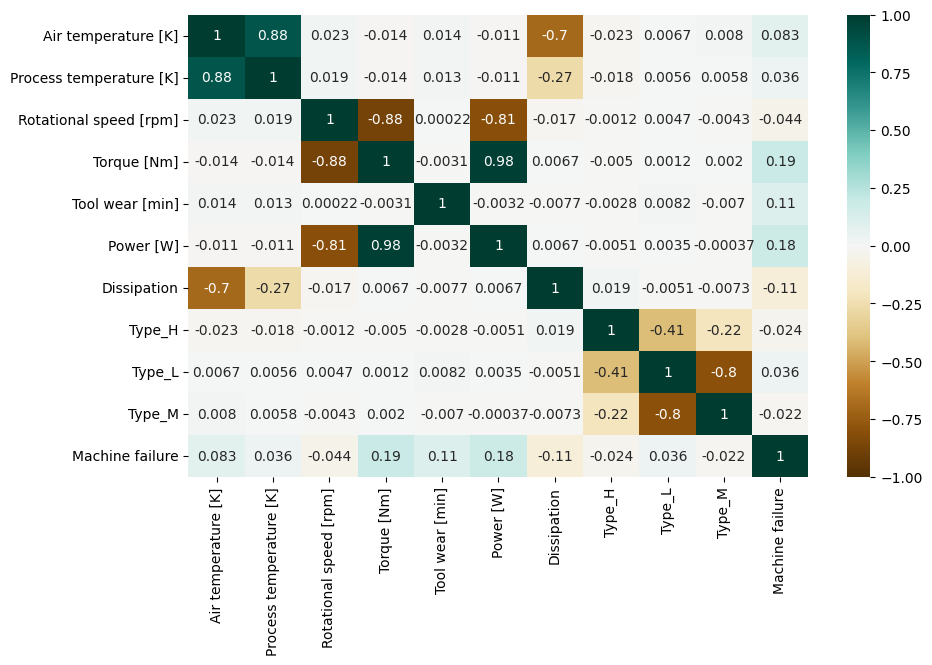

In [16]:
plt.figure(figsize=(10,6))
sns.heatmap(df.drop(['TWF','HDF','PWF','OSF'],axis=1).corr(numeric_only=True),annot=True,cmap='BrBG',vmin=-1,vmax=1)

## MODELING

In [38]:
X=df.drop(['Product ID','Machine failure','Torque [Nm]','Rotational speed [rpm]','Air temperature [K]','Process temperature [K]','TWF','HDF','PWF','OSF'],axis=1)
y=df['Machine failure']

In [39]:
X.head(5)

,Tool wear [min],Power [W],Dissipation,Type_H,Type_L,Type_M
UDI,,,,,,
1,0,6951.590560,10.5,False,False,True
2,3,6826.722724,10.5,False,True,False
3,5,7749.387543,10.4,False,True,False
4,7,5927.504659,10.4,False,True,False
5,9,5897.816608,10.5,False,True,False


Debido a qué tenemos un gran número de 1 más que 0 probaremos a hacer un under sampler posteriormente por si mejora:

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 6)
(2000, 6)
(8000,)
(2000,)


In [41]:
oversampler = RandomOverSampler(random_state=42)
X_over_resampled, y_over_resampled = oversampler.fit_resample(X_train, y_train)

X_over_resampled.shape,y_over_resampled.shape

((15458, 6), (15458,))

In [42]:
undersampler = RandomUnderSampler(random_state=42)
X_under_resampled, y_under_resampled = undersampler.fit_resample(X_train, y_train)

X_under_resampled.shape,y_under_resampled.shape

((542, 6), (542,))

In [43]:
pipe = Pipeline(steps=[("selectkbest", SelectKBest()),
    ("scaler", StandardScaler()),
    ('classifier', svm.SVC())
])

""" logistic_params = {
    'selectkbest__k': [3,4,5,'all'],
    'classifier': [LogisticRegression(max_iter=10000, solver='liblinear'), LogisticRegression(max_iter=1000, solver='liblinear')],
    'classifier__penalty': ['l1', 'l2']
} """
random_forest_params = {
    'selectkbest__k': [3,4,5,'all'],
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [RandomForestClassifier(random_state=42)],
    'classifier__max_depth': [2,3,4]
}

svm_param = {
    'selectkbest__k': [3,4,5,'all'],
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [svm.SVC(probability=True, random_state=42)],
    'classifier__C': [10, 100, 150],
}

#PROBAR NAIVE BAYES
""" 
xgb_param = {
    'classifier': [xgboost.XGBClassifier(random_state=100)],
    #'classifier__n_estimators': [10,20,50,100],
    #'classifier__learning_rate': [0.1,0.5,1],
    'classifier__max_depth': [2,3,4]
} """

search_space = [
    #logistic_params,
    random_forest_params,
    svm_param,
    #xgb_param
]

clf = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = KFold(5),
                  scoring='recall',
                  verbose=2,
                  n_jobs=-1)


#### UNDERSAMPLER:

In [44]:
""" clf.fit(X_under_resampled, y_under_resampled)
model_under_resampled=clf.best_estimator_
model_under_resampled """

' clf.fit(X_under_resampled, y_under_resampled)\nmodel_under_resampled=clf.best_estimator_\nmodel_under_resampled '

In [45]:
""" predictions_under=model_under_resampled.predict(X_test) """

' predictions_under=model_under_resampled.predict(X_test) '

In [46]:
""" pd.DataFrame(index=['accuracy','precision','recall','confusion_matrix','roc_auc'],columns=['results_model'],data=[accuracy_score(y_test, predictions_under),precision_score(y_test, predictions_under),recall_score(y_test, predictions_under),confusion_matrix(y_test,predictions_under),roc_auc_score(y_test, predictions_under)]) """

" pd.DataFrame(index=['accuracy','precision','recall','confusion_matrix','roc_auc'],columns=['results_model'],data=[accuracy_score(y_test, predictions_under),precision_score(y_test, predictions_under),recall_score(y_test, predictions_under),confusion_matrix(y_test,predictions_under),roc_auc_score(y_test, predictions_under)]) "

In [47]:
""" plt.figure(figsize=(3,2))
plt.title('Matrix_confusion_under_resampled')
sns.heatmap(confusion_matrix(y_test,predictions_under),cmap='BrBG', annot=True,fmt='.0f',); """

" plt.figure(figsize=(3,2))\nplt.title('Matrix_confusion_under_resampled')\nsns.heatmap(confusion_matrix(y_test,predictions_under),cmap='BrBG', annot=True,fmt='.0f',); "

In [48]:
""" plt.figure(figsize=(3,2))
sns.heatmap(confusion_matrix(y,model_under_resampled.predict(X)),cmap='BrBG', annot=True,fmt='.0f',);
plt.title('Matrix_confusion_under_resampled')  """

" plt.figure(figsize=(3,2))\nsns.heatmap(confusion_matrix(y,model_under_resampled.predict(X)),cmap='BrBG', annot=True,fmt='.0f',);\nplt.title('Matrix_confusion_under_resampled')  "

El valor que ha dado el modelo a las diferentes features es:

In [49]:
""" #Al ser un randomForest el modelo elegido, valoramos los pesos de las features dado:

best_pipeline = model_under_resampled.best_estimator_
# Accede al modelo dentro del pipeline por su nombre
model = best_pipeline.named_steps['classifier']

# Visualiza las importancias de las features en el caso de randomForest
importances = model.feature_importances_ 

#Creamos un dataframe:
pd.DataFrame(index=X_train.columns,data=importances,columns=['Features']) """

" #Al ser un randomForest el modelo elegido, valoramos los pesos de las features dado:\n\nbest_pipeline = model_under_resampled.best_estimator_\n# Accede al modelo dentro del pipeline por su nombre\nmodel = best_pipeline.named_steps['classifier']\n\n# Visualiza las importancias de las features en el caso de randomForest\nimportances = model.feature_importances_ \n\n#Creamos un dataframe:\npd.DataFrame(index=X_train.columns,data=importances,columns=['Features']) "

#### OVERSAMPLER:

In [50]:
clf.fit(X_over_resampled, y_over_resampled)
model_over_resampled=clf.best_estimator_
model_over_resampled

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Pipeline(steps=[('selectkbest', SelectKBest(k=4)), ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=4, random_state=42))])

In [51]:
predictions_over=model_over_resampled.predict(X_test)
predictions_proba = model_over_resampled.predict_proba(X_test)

In [52]:
print(np.round(predictions_proba[:5], 2))


[[0.3  0.7 ]
 [0.87 0.13]
 [0.37 0.63]
 [0.9  0.1 ]
 [0.37 0.63]]


In [53]:
pd.DataFrame(index=['accuracy','precision','recall','confusion_matrix','roc_auc'],columns=['results_model'],data=[accuracy_score(y_test, predictions_over),precision_score(y_test, predictions_over),recall_score(y_test, predictions_over),confusion_matrix(y_test,predictions_over),roc_auc_score(y_test, predictions_over)])

,results_model
accuracy,0.9025
precision,0.249012
recall,0.926471
confusion_matrix,"[[1742, 190], [5, 63]]"
roc_auc,0.914063


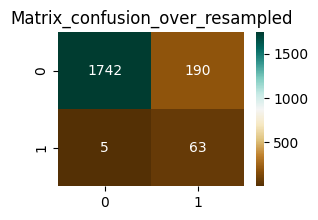

In [54]:
plt.figure(figsize=(3,2))
plt.title('Matrix_confusion_over_resampled')
sns.heatmap(confusion_matrix(y_test,predictions_over),cmap='BrBG', annot=True,fmt='.0f',);

Text(0.5, 1.0, 'Matrix_confusion_over_resampled')

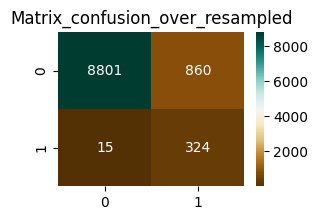

In [55]:
plt.figure(figsize=(3,2))
sns.heatmap(confusion_matrix(y,model_over_resampled.predict(X)),cmap='BrBG', annot=True,fmt='.0f',);
plt.title('Matrix_confusion_over_resampled')

In [56]:
skbest = model_over_resampled.named_steps["selectkbest"]
selected_indices = skbest.get_support(indices=True)
feature_names = X.columns[selected_indices]
print(feature_names)
scores = skbest.scores_  # Puntuaciones de todas las features
print(scores[selected_indices])  # Solo las seleccionadas


Index(['Tool wear [min]', 'Power [W]', 'Dissipation', 'Type_L'], dtype='object')
[ 968.54957939 1892.25345406 1227.00530049  313.49720875]


### ESTADÍSITCAS DE LOS TRES MODELOS:

In [57]:
""" plt.figure(figsize=(2,1))
print(classification_report(y_test, predictions_under))
plt.title('Matrix_confusion_under_resampled')
sns.heatmap(confusion_matrix(y_test,predictions_under),cmap='BrBG', annot=True,fmt='.0f',); """

" plt.figure(figsize=(2,1))\nprint(classification_report(y_test, predictions_under))\nplt.title('Matrix_confusion_under_resampled')\nsns.heatmap(confusion_matrix(y_test,predictions_under),cmap='BrBG', annot=True,fmt='.0f',); "

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1932
           1       0.25      0.93      0.39        68

    accuracy                           0.90      2000
   macro avg       0.62      0.91      0.67      2000
weighted avg       0.97      0.90      0.93      2000



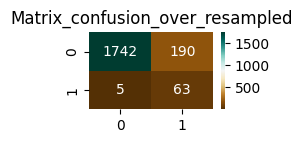

In [58]:
plt.figure(figsize=(2,1))
print(classification_report(y_test, predictions_over))
plt.title('Matrix_confusion_over_resampled')
sns.heatmap(confusion_matrix(y_test,predictions_over),cmap='BrBG', annot=True,fmt='.0f',);